In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'elu',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

elu_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_1_coords_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 831)
(772408, 8)
validation
(101248, 831)
(101248, 8)
test
(98888, 831)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1542024 (5.88 MB)


Trainable params: 1542024 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/78 [..............................] - ETA: 1:38 - loss: 2.2126 - STD: 0.0560 - MAE: 0.2202

 5/78 [>.............................] - ETA: 1s - loss: 3.0176 - STD: 0.2147 - MAE: 0.1729  

 9/78 [==>...........................] - ETA: 1s - loss: 2.4371 - STD: 0.2204 - MAE: 0.1560

13/78 [====>.........................] - ETA: 1s - loss: 2.1291 - STD: 0.2136 - MAE: 0.1519

17/78 [=====>........................] - ETA: 0s - loss: 1.9653 - STD: 0.2094 - MAE: 0.1496

21/78 [=======>......................] - ETA: 0s - loss: 1.8355 - STD: 0.2082 - MAE: 0.1474

25/78 [========>.....................] - ETA: 0s - loss: 1.7443 - STD: 0.2068 - MAE: 0.1460

29/78 [==========>...................] - ETA: 0s - loss: 1.6739 - STD: 0.2052 - MAE: 0.1452

33/78 [===========>..................] - ETA: 0s - loss: 1.6203 - STD: 0.2050 - MAE: 0.1442

37/78 [=============>................] - ETA: 0s - loss: 1.5753 - STD: 0.2047 - MAE: 0.1433

41/78 [==============>...............] - ETA: 0s - loss: 1.5379 - STD: 0.2042 - MAE: 0.1428

45/78 [================>.............] - ETA: 0s - loss: 1.5046 - STD: 0.2040 - MAE: 0.1421

47/78 [=================>............] - ETA: 0s - loss: 1.4950 - STD: 0.2041 - MAE: 0.1417

51/78 [==================>...........] - ETA: 0s - loss: 1.4667 - STD: 0.2038 - MAE: 0.1412

55/78 [====================>.........] - ETA: 0s - loss: 1.4413 - STD: 0.2043 - MAE: 0.1404

59/78 [=====================>........] - ETA: 0s - loss: 1.4187 - STD: 0.2047 - MAE: 0.1397

63/78 [=======================>......] - ETA: 0s - loss: 1.3983 - STD: 0.2047 - MAE: 0.1393

67/78 [========================>.....] - ETA: 0s - loss: 1.3805 - STD: 0.2047 - MAE: 0.1389

71/78 [==========================>...] - ETA: 0s - loss: 1.3648 - STD: 0.2054 - MAE: 0.1383

75/78 [===========================>..] - ETA: 0s - loss: 1.3486 - STD: 0.2055 - MAE: 0.1378

78/78 [==============================] - 4s 32ms/step - loss: 1.3372 - STD: 0.2058 - MAE: 0.1375 - val_loss: 1.0083 - val_STD: 0.2214 - val_MAE: 0.1231


Epoch 2/10000


 1/78 [..............................] - ETA: 3s - loss: 1.0565 - STD: 0.2213 - MAE: 0.1243

 5/78 [>.............................] - ETA: 1s - loss: 1.0289 - STD: 0.2120 - MAE: 0.1271

 9/78 [==>...........................] - ETA: 1s - loss: 1.0245 - STD: 0.2142 - MAE: 0.1261

13/78 [====>.........................] - ETA: 1s - loss: 1.0163 - STD: 0.2147 - MAE: 0.1256

17/78 [=====>........................] - ETA: 0s - loss: 1.0083 - STD: 0.2155 - MAE: 0.1249

21/78 [=======>......................] - ETA: 0s - loss: 1.0044 - STD: 0.2161 - MAE: 0.1246

25/78 [========>.....................] - ETA: 0s - loss: 0.9974 - STD: 0.2167 - MAE: 0.1240

29/78 [==========>...................] - ETA: 0s - loss: 0.9938 - STD: 0.2170 - MAE: 0.1237

34/78 [============>.................] - ETA: 0s - loss: 0.9901 - STD: 0.2179 - MAE: 0.1232

38/78 [=============>................] - ETA: 0s - loss: 0.9856 - STD: 0.2188 - MAE: 0.1226

42/78 [===============>..............] - ETA: 0s - loss: 0.9839 - STD: 0.2187 - MAE: 0.1225

46/78 [================>.............] - ETA: 0s - loss: 0.9800 - STD: 0.2193 - MAE: 0.1221

50/78 [==================>...........] - ETA: 0s - loss: 0.9757 - STD: 0.2195 - MAE: 0.1218

54/78 [===================>..........] - ETA: 0s - loss: 0.9721 - STD: 0.2196 - MAE: 0.1216

58/78 [=====================>........] - ETA: 0s - loss: 0.9682 - STD: 0.2202 - MAE: 0.1212

62/78 [======================>.......] - ETA: 0s - loss: 0.9661 - STD: 0.2206 - MAE: 0.1209

66/78 [========================>.....] - ETA: 0s - loss: 0.9635 - STD: 0.2207 - MAE: 0.1208

70/78 [=========================>....] - ETA: 0s - loss: 0.9617 - STD: 0.2213 - MAE: 0.1205

74/78 [===========================>..] - ETA: 0s - loss: 0.9602 - STD: 0.2215 - MAE: 0.1203

78/78 [==============================] - ETA: 0s - loss: 0.9582 - STD: 0.2216 - MAE: 0.1202

78/78 [==============================] - 1s 18ms/step - loss: 0.9582 - STD: 0.2216 - MAE: 0.1202 - val_loss: 0.9273 - val_STD: 0.2054 - val_MAE: 0.1265


Epoch 3/10000


 1/78 [..............................] - ETA: 3s - loss: 0.9300 - STD: 0.2070 - MAE: 0.1254

 5/78 [>.............................] - ETA: 1s - loss: 0.9146 - STD: 0.2223 - MAE: 0.1179

 9/78 [==>...........................] - ETA: 1s - loss: 0.9121 - STD: 0.2240 - MAE: 0.1170

13/78 [====>.........................] - ETA: 0s - loss: 0.9068 - STD: 0.2256 - MAE: 0.1161

17/78 [=====>........................] - ETA: 0s - loss: 0.9036 - STD: 0.2255 - MAE: 0.1160

21/78 [=======>......................] - ETA: 0s - loss: 0.9044 - STD: 0.2260 - MAE: 0.1158

25/78 [========>.....................] - ETA: 0s - loss: 0.9068 - STD: 0.2269 - MAE: 0.1156

29/78 [==========>...................] - ETA: 0s - loss: 0.9047 - STD: 0.2266 - MAE: 0.1157

33/78 [===========>..................] - ETA: 0s - loss: 0.9019 - STD: 0.2264 - MAE: 0.1156

37/78 [=============>................] - ETA: 0s - loss: 0.9003 - STD: 0.2264 - MAE: 0.1156

41/78 [==============>...............] - ETA: 0s - loss: 0.8979 - STD: 0.2268 - MAE: 0.1153

45/78 [================>.............] - ETA: 0s - loss: 0.8970 - STD: 0.2266 - MAE: 0.1153

49/78 [=================>............] - ETA: 0s - loss: 0.8981 - STD: 0.2270 - MAE: 0.1152

53/78 [===================>..........] - ETA: 0s - loss: 0.8961 - STD: 0.2271 - MAE: 0.1151

57/78 [====================>.........] - ETA: 0s - loss: 0.8942 - STD: 0.2273 - MAE: 0.1149

61/78 [======================>.......] - ETA: 0s - loss: 0.8925 - STD: 0.2274 - MAE: 0.1148

65/78 [========================>.....] - ETA: 0s - loss: 0.8910 - STD: 0.2274 - MAE: 0.1147

69/78 [=========================>....] - ETA: 0s - loss: 0.8900 - STD: 0.2277 - MAE: 0.1146

73/78 [===========================>..] - ETA: 0s - loss: 0.8899 - STD: 0.2278 - MAE: 0.1145

77/78 [============================>.] - ETA: 0s - loss: 0.8886 - STD: 0.2278 - MAE: 0.1144

78/78 [==============================] - 1s 18ms/step - loss: 0.8882 - STD: 0.2279 - MAE: 0.1144 - val_loss: 0.8583 - val_STD: 0.2266 - val_MAE: 0.1142


Epoch 4/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8385 - STD: 0.2296 - MAE: 0.1112

 4/78 [>.............................] - ETA: 1s - loss: 0.8581 - STD: 0.2309 - MAE: 0.1117

 8/78 [==>...........................] - ETA: 1s - loss: 0.8710 - STD: 0.2314 - MAE: 0.1122

12/78 [===>..........................] - ETA: 1s - loss: 0.8725 - STD: 0.2308 - MAE: 0.1125

16/78 [=====>........................] - ETA: 0s - loss: 0.8713 - STD: 0.2309 - MAE: 0.1124

20/78 [======>.......................] - ETA: 0s - loss: 0.8703 - STD: 0.2305 - MAE: 0.1124

24/78 [========>.....................] - ETA: 0s - loss: 0.8706 - STD: 0.2311 - MAE: 0.1122

28/78 [=========>....................] - ETA: 0s - loss: 0.8746 - STD: 0.2307 - MAE: 0.1127

32/78 [===========>..................] - ETA: 0s - loss: 0.8756 - STD: 0.2307 - MAE: 0.1127

36/78 [============>.................] - ETA: 0s - loss: 0.8742 - STD: 0.2304 - MAE: 0.1128

40/78 [==============>...............] - ETA: 0s - loss: 0.8711 - STD: 0.2305 - MAE: 0.1125

44/78 [===============>..............] - ETA: 0s - loss: 0.8688 - STD: 0.2307 - MAE: 0.1123

48/78 [=================>............] - ETA: 0s - loss: 0.8677 - STD: 0.2307 - MAE: 0.1123

52/78 [===================>..........] - ETA: 0s - loss: 0.8669 - STD: 0.2311 - MAE: 0.1121

56/78 [====================>.........] - ETA: 0s - loss: 0.8662 - STD: 0.2309 - MAE: 0.1121

60/78 [======================>.......] - ETA: 0s - loss: 0.8656 - STD: 0.2312 - MAE: 0.1120

64/78 [=======================>......] - ETA: 0s - loss: 0.8652 - STD: 0.2309 - MAE: 0.1121

68/78 [=========================>....] - ETA: 0s - loss: 0.8640 - STD: 0.2311 - MAE: 0.1119

72/78 [==========================>...] - ETA: 0s - loss: 0.8626 - STD: 0.2311 - MAE: 0.1118

76/78 [============================>.] - ETA: 0s - loss: 0.8616 - STD: 0.2312 - MAE: 0.1117

78/78 [==============================] - 1s 18ms/step - loss: 0.8613 - STD: 0.2312 - MAE: 0.1117 - val_loss: 0.8791 - val_STD: 0.2494 - val_MAE: 0.1052


Epoch 5/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8908 - STD: 0.2526 - MAE: 0.1045

 5/78 [>.............................] - ETA: 1s - loss: 0.8617 - STD: 0.2355 - MAE: 0.1100

 9/78 [==>...........................] - ETA: 1s - loss: 0.8526 - STD: 0.2349 - MAE: 0.1096

13/78 [====>.........................] - ETA: 1s - loss: 0.8488 - STD: 0.2339 - MAE: 0.1099

17/78 [=====>........................] - ETA: 0s - loss: 0.8448 - STD: 0.2331 - MAE: 0.1101

21/78 [=======>......................] - ETA: 0s - loss: 0.8439 - STD: 0.2334 - MAE: 0.1099

25/78 [========>.....................] - ETA: 0s - loss: 0.8424 - STD: 0.2328 - MAE: 0.1101

29/78 [==========>...................] - ETA: 0s - loss: 0.8407 - STD: 0.2331 - MAE: 0.1098

33/78 [===========>..................] - ETA: 0s - loss: 0.8378 - STD: 0.2333 - MAE: 0.1096

37/78 [=============>................] - ETA: 0s - loss: 0.8348 - STD: 0.2335 - MAE: 0.1093

41/78 [==============>...............] - ETA: 0s - loss: 0.8326 - STD: 0.2337 - MAE: 0.1091

45/78 [================>.............] - ETA: 0s - loss: 0.8301 - STD: 0.2339 - MAE: 0.1089

49/78 [=================>............] - ETA: 0s - loss: 0.8338 - STD: 0.2345 - MAE: 0.1088

53/78 [===================>..........] - ETA: 0s - loss: 0.8377 - STD: 0.2343 - MAE: 0.1092

57/78 [====================>.........] - ETA: 0s - loss: 0.8375 - STD: 0.2345 - MAE: 0.1091

61/78 [======================>.......] - ETA: 0s - loss: 0.8366 - STD: 0.2343 - MAE: 0.1092

65/78 [========================>.....] - ETA: 0s - loss: 0.8355 - STD: 0.2343 - MAE: 0.1092

69/78 [=========================>....] - ETA: 0s - loss: 0.8345 - STD: 0.2342 - MAE: 0.1091

74/78 [===========================>..] - ETA: 0s - loss: 0.8336 - STD: 0.2342 - MAE: 0.1091

78/78 [==============================] - ETA: 0s - loss: 0.8329 - STD: 0.2343 - MAE: 0.1090

78/78 [==============================] - 1s 18ms/step - loss: 0.8329 - STD: 0.2343 - MAE: 0.1090 - val_loss: 0.8172 - val_STD: 0.2295 - val_MAE: 0.1106


Epoch 6/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8242 - STD: 0.2339 - MAE: 0.1086

 5/78 [>.............................] - ETA: 1s - loss: 0.8066 - STD: 0.2358 - MAE: 0.1068

 9/78 [==>...........................] - ETA: 1s - loss: 0.8036 - STD: 0.2354 - MAE: 0.1069

13/78 [====>.........................] - ETA: 1s - loss: 0.8076 - STD: 0.2360 - MAE: 0.1067

17/78 [=====>........................] - ETA: 0s - loss: 0.8172 - STD: 0.2365 - MAE: 0.1070

21/78 [=======>......................] - ETA: 0s - loss: 0.8262 - STD: 0.2376 - MAE: 0.1070

25/78 [========>.....................] - ETA: 0s - loss: 0.8325 - STD: 0.2373 - MAE: 0.1075

29/78 [==========>...................] - ETA: 0s - loss: 0.8357 - STD: 0.2367 - MAE: 0.1080

33/78 [===========>..................] - ETA: 0s - loss: 0.8367 - STD: 0.2360 - MAE: 0.1084

37/78 [=============>................] - ETA: 0s - loss: 0.8344 - STD: 0.2358 - MAE: 0.1083

41/78 [==============>...............] - ETA: 0s - loss: 0.8326 - STD: 0.2357 - MAE: 0.1083

45/78 [================>.............] - ETA: 0s - loss: 0.8307 - STD: 0.2355 - MAE: 0.1083

49/78 [=================>............] - ETA: 0s - loss: 0.8278 - STD: 0.2355 - MAE: 0.1081

52/78 [===================>..........] - ETA: 0s - loss: 0.8260 - STD: 0.2357 - MAE: 0.1080

56/78 [====================>.........] - ETA: 0s - loss: 0.8229 - STD: 0.2358 - MAE: 0.1078

60/78 [======================>.......] - ETA: 0s - loss: 0.8206 - STD: 0.2359 - MAE: 0.1076

64/78 [=======================>......] - ETA: 0s - loss: 0.8187 - STD: 0.2360 - MAE: 0.1075

68/78 [=========================>....] - ETA: 0s - loss: 0.8173 - STD: 0.2361 - MAE: 0.1073

72/78 [==========================>...] - ETA: 0s - loss: 0.8155 - STD: 0.2362 - MAE: 0.1072

76/78 [============================>.] - ETA: 0s - loss: 0.8136 - STD: 0.2363 - MAE: 0.1071

78/78 [==============================] - 1s 18ms/step - loss: 0.8130 - STD: 0.2364 - MAE: 0.1070 - val_loss: 0.8028 - val_STD: 0.2243 - val_MAE: 0.1126


Epoch 7/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7886 - STD: 0.2304 - MAE: 0.1088

 5/78 [>.............................] - ETA: 1s - loss: 0.7902 - STD: 0.2376 - MAE: 0.1051

 9/78 [==>...........................] - ETA: 1s - loss: 0.7859 - STD: 0.2379 - MAE: 0.1049

12/78 [===>..........................] - ETA: 1s - loss: 0.7902 - STD: 0.2390 - MAE: 0.1046

16/78 [=====>........................] - ETA: 0s - loss: 0.7851 - STD: 0.2390 - MAE: 0.1042

20/78 [======>.......................] - ETA: 0s - loss: 0.7818 - STD: 0.2391 - MAE: 0.1040

24/78 [========>.....................] - ETA: 0s - loss: 0.7811 - STD: 0.2391 - MAE: 0.1040

28/78 [=========>....................] - ETA: 0s - loss: 0.7837 - STD: 0.2392 - MAE: 0.1042

32/78 [===========>..................] - ETA: 0s - loss: 0.7842 - STD: 0.2390 - MAE: 0.1043

36/78 [============>.................] - ETA: 0s - loss: 0.7825 - STD: 0.2390 - MAE: 0.1042

40/78 [==============>...............] - ETA: 0s - loss: 0.7908 - STD: 0.2388 - MAE: 0.1046

44/78 [===============>..............] - ETA: 0s - loss: 0.7932 - STD: 0.2388 - MAE: 0.1047

47/78 [=================>............] - ETA: 0s - loss: 0.7933 - STD: 0.2386 - MAE: 0.1049

51/78 [==================>...........] - ETA: 0s - loss: 0.7933 - STD: 0.2386 - MAE: 0.1049

55/78 [====================>.........] - ETA: 0s - loss: 0.7931 - STD: 0.2388 - MAE: 0.1048

59/78 [=====================>........] - ETA: 0s - loss: 0.7921 - STD: 0.2387 - MAE: 0.1047

63/78 [=======================>......] - ETA: 0s - loss: 0.7924 - STD: 0.2388 - MAE: 0.1047

67/78 [========================>.....] - ETA: 0s - loss: 0.7923 - STD: 0.2389 - MAE: 0.1047

71/78 [==========================>...] - ETA: 0s - loss: 0.7934 - STD: 0.2389 - MAE: 0.1048

75/78 [===========================>..] - ETA: 0s - loss: 0.7936 - STD: 0.2389 - MAE: 0.1048

78/78 [==============================] - 1s 18ms/step - loss: 0.7932 - STD: 0.2388 - MAE: 0.1048 - val_loss: 0.7834 - val_STD: 0.2352 - val_MAE: 0.1066


Epoch 8/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7561 - STD: 0.2415 - MAE: 0.1013

 5/78 [>.............................] - ETA: 1s - loss: 0.7730 - STD: 0.2393 - MAE: 0.1034

 9/78 [==>...........................] - ETA: 1s - loss: 0.7700 - STD: 0.2395 - MAE: 0.1031

13/78 [====>.........................] - ETA: 1s - loss: 0.7917 - STD: 0.2414 - MAE: 0.1034

17/78 [=====>........................] - ETA: 0s - loss: 0.8059 - STD: 0.2410 - MAE: 0.1044

21/78 [=======>......................] - ETA: 0s - loss: 0.8124 - STD: 0.2414 - MAE: 0.1046

25/78 [========>.....................] - ETA: 0s - loss: 0.8113 - STD: 0.2403 - MAE: 0.1050

29/78 [==========>...................] - ETA: 0s - loss: 0.8092 - STD: 0.2396 - MAE: 0.1053

33/78 [===========>..................] - ETA: 0s - loss: 0.8052 - STD: 0.2391 - MAE: 0.1053

36/78 [============>.................] - ETA: 0s - loss: 0.8039 - STD: 0.2393 - MAE: 0.1052

40/78 [==============>...............] - ETA: 0s - loss: 0.8002 - STD: 0.2391 - MAE: 0.1051

44/78 [===============>..............] - ETA: 0s - loss: 0.7980 - STD: 0.2391 - MAE: 0.1049

48/78 [=================>............] - ETA: 0s - loss: 0.7956 - STD: 0.2391 - MAE: 0.1048

52/78 [===================>..........] - ETA: 0s - loss: 0.7925 - STD: 0.2391 - MAE: 0.1046

55/78 [====================>.........] - ETA: 0s - loss: 0.7906 - STD: 0.2393 - MAE: 0.1044

59/78 [=====================>........] - ETA: 0s - loss: 0.7888 - STD: 0.2395 - MAE: 0.1042

63/78 [=======================>......] - ETA: 0s - loss: 0.7874 - STD: 0.2398 - MAE: 0.1041

67/78 [========================>.....] - ETA: 0s - loss: 0.7866 - STD: 0.2399 - MAE: 0.1040

71/78 [==========================>...] - ETA: 0s - loss: 0.7854 - STD: 0.2399 - MAE: 0.1039

75/78 [===========================>..] - ETA: 0s - loss: 0.7839 - STD: 0.2399 - MAE: 0.1038

78/78 [==============================] - 1s 18ms/step - loss: 0.7829 - STD: 0.2399 - MAE: 0.1038 - val_loss: 0.7896 - val_STD: 0.2393 - val_MAE: 0.1048


Epoch 9/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7599 - STD: 0.2428 - MAE: 0.1009

 5/78 [>.............................] - ETA: 1s - loss: 0.7462 - STD: 0.2406 - MAE: 0.1016

 9/78 [==>...........................] - ETA: 1s - loss: 0.7476 - STD: 0.2407 - MAE: 0.1015

13/78 [====>.........................] - ETA: 0s - loss: 0.7489 - STD: 0.2414 - MAE: 0.1012

17/78 [=====>........................] - ETA: 0s - loss: 0.7537 - STD: 0.2414 - MAE: 0.1015

21/78 [=======>......................] - ETA: 0s - loss: 0.7573 - STD: 0.2420 - MAE: 0.1014

25/78 [========>.....................] - ETA: 0s - loss: 0.7595 - STD: 0.2418 - MAE: 0.1016

29/78 [==========>...................] - ETA: 0s - loss: 0.7608 - STD: 0.2415 - MAE: 0.1018

33/78 [===========>..................] - ETA: 0s - loss: 0.7614 - STD: 0.2416 - MAE: 0.1018

37/78 [=============>................] - ETA: 0s - loss: 0.7603 - STD: 0.2416 - MAE: 0.1018

41/78 [==============>...............] - ETA: 0s - loss: 0.7597 - STD: 0.2415 - MAE: 0.1018

45/78 [================>.............] - ETA: 0s - loss: 0.7593 - STD: 0.2418 - MAE: 0.1017

49/78 [=================>............] - ETA: 0s - loss: 0.7577 - STD: 0.2419 - MAE: 0.1015

53/78 [===================>..........] - ETA: 0s - loss: 0.7565 - STD: 0.2417 - MAE: 0.1015

57/78 [====================>.........] - ETA: 0s - loss: 0.7561 - STD: 0.2418 - MAE: 0.1015

61/78 [======================>.......] - ETA: 0s - loss: 0.7553 - STD: 0.2418 - MAE: 0.1014

65/78 [========================>.....] - ETA: 0s - loss: 0.7539 - STD: 0.2418 - MAE: 0.1014

69/78 [=========================>....] - ETA: 0s - loss: 0.7537 - STD: 0.2419 - MAE: 0.1013

73/78 [===========================>..] - ETA: 0s - loss: 0.7542 - STD: 0.2420 - MAE: 0.1013

77/78 [============================>.] - ETA: 0s - loss: 0.7550 - STD: 0.2420 - MAE: 0.1013

78/78 [==============================] - 1s 18ms/step - loss: 0.7569 - STD: 0.2423 - MAE: 0.1013 - val_loss: 0.7783 - val_STD: 0.2262 - val_MAE: 0.1119


Epoch 10/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7698 - STD: 0.2291 - MAE: 0.1086

 5/78 [>.............................] - ETA: 1s - loss: 0.9164 - STD: 0.2425 - MAE: 0.1081

 9/78 [==>...........................] - ETA: 1s - loss: 0.8953 - STD: 0.2430 - MAE: 0.1074

13/78 [====>.........................] - ETA: 1s - loss: 0.8765 - STD: 0.2391 - MAE: 0.1086

17/78 [=====>........................] - ETA: 0s - loss: 0.8608 - STD: 0.2384 - MAE: 0.1082

21/78 [=======>......................] - ETA: 0s - loss: 0.8465 - STD: 0.2383 - MAE: 0.1076

25/78 [========>.....................] - ETA: 0s - loss: 0.8359 - STD: 0.2390 - MAE: 0.1066

29/78 [==========>...................] - ETA: 0s - loss: 0.8268 - STD: 0.2390 - MAE: 0.1062

33/78 [===========>..................] - ETA: 0s - loss: 0.8184 - STD: 0.2392 - MAE: 0.1057

37/78 [=============>................] - ETA: 0s - loss: 0.8106 - STD: 0.2397 - MAE: 0.1051

41/78 [==============>...............] - ETA: 0s - loss: 0.8039 - STD: 0.2397 - MAE: 0.1048

45/78 [================>.............] - ETA: 0s - loss: 0.7987 - STD: 0.2399 - MAE: 0.1044

49/78 [=================>............] - ETA: 0s - loss: 0.7936 - STD: 0.2401 - MAE: 0.1041

53/78 [===================>..........] - ETA: 0s - loss: 0.7882 - STD: 0.2404 - MAE: 0.1036

57/78 [====================>.........] - ETA: 0s - loss: 0.7844 - STD: 0.2407 - MAE: 0.1033

61/78 [======================>.......] - ETA: 0s - loss: 0.7808 - STD: 0.2408 - MAE: 0.1031

65/78 [========================>.....] - ETA: 0s - loss: 0.7777 - STD: 0.2410 - MAE: 0.1028

69/78 [=========================>....] - ETA: 0s - loss: 0.7748 - STD: 0.2412 - MAE: 0.1026

73/78 [===========================>..] - ETA: 0s - loss: 0.7722 - STD: 0.2413 - MAE: 0.1024

77/78 [============================>.] - ETA: 0s - loss: 0.7698 - STD: 0.2415 - MAE: 0.1022

78/78 [==============================] - 1s 18ms/step - loss: 0.7692 - STD: 0.2416 - MAE: 0.1021 - val_loss: 0.7944 - val_STD: 0.2401 - val_MAE: 0.1044


Epoch 11/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7355 - STD: 0.2458 - MAE: 0.0980

 5/78 [>.............................] - ETA: 1s - loss: 0.7306 - STD: 0.2439 - MAE: 0.0990

 9/78 [==>...........................] - ETA: 1s - loss: 0.7341 - STD: 0.2441 - MAE: 0.0992

13/78 [====>.........................] - ETA: 1s - loss: 0.7344 - STD: 0.2445 - MAE: 0.0990

17/78 [=====>........................] - ETA: 0s - loss: 0.7329 - STD: 0.2439 - MAE: 0.0992

21/78 [=======>......................] - ETA: 0s - loss: 0.7336 - STD: 0.2446 - MAE: 0.0989

25/78 [========>.....................] - ETA: 0s - loss: 0.7299 - STD: 0.2445 - MAE: 0.0987

29/78 [==========>...................] - ETA: 0s - loss: 0.7284 - STD: 0.2445 - MAE: 0.0987

33/78 [===========>..................] - ETA: 0s - loss: 0.7273 - STD: 0.2446 - MAE: 0.0986

37/78 [=============>................] - ETA: 0s - loss: 0.7262 - STD: 0.2445 - MAE: 0.0986

41/78 [==============>...............] - ETA: 0s - loss: 0.7284 - STD: 0.2447 - MAE: 0.0986

45/78 [================>.............] - ETA: 0s - loss: 0.7280 - STD: 0.2447 - MAE: 0.0986

49/78 [=================>............] - ETA: 0s - loss: 0.7282 - STD: 0.2446 - MAE: 0.0986

53/78 [===================>..........] - ETA: 0s - loss: 0.7294 - STD: 0.2449 - MAE: 0.0986

57/78 [====================>.........] - ETA: 0s - loss: 0.7299 - STD: 0.2447 - MAE: 0.0987

62/78 [======================>.......] - ETA: 0s - loss: 0.7299 - STD: 0.2447 - MAE: 0.0987

66/78 [========================>.....] - ETA: 0s - loss: 0.7294 - STD: 0.2447 - MAE: 0.0987

70/78 [=========================>....] - ETA: 0s - loss: 0.7291 - STD: 0.2447 - MAE: 0.0987

74/78 [===========================>..] - ETA: 0s - loss: 0.7289 - STD: 0.2446 - MAE: 0.0987

78/78 [==============================] - ETA: 0s - loss: 0.7287 - STD: 0.2447 - MAE: 0.0987

78/78 [==============================] - 1s 18ms/step - loss: 0.7287 - STD: 0.2447 - MAE: 0.0987 - val_loss: 0.7457 - val_STD: 0.2426 - val_MAE: 0.1012


Epoch 12/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7142 - STD: 0.2491 - MAE: 0.0960

 5/78 [>.............................] - ETA: 1s - loss: 0.7137 - STD: 0.2461 - MAE: 0.0972

 9/78 [==>...........................] - ETA: 1s - loss: 0.7247 - STD: 0.2461 - MAE: 0.0978

13/78 [====>.........................] - ETA: 1s - loss: 0.7315 - STD: 0.2458 - MAE: 0.0983

17/78 [=====>........................] - ETA: 0s - loss: 0.7304 - STD: 0.2453 - MAE: 0.0984

21/78 [=======>......................] - ETA: 0s - loss: 0.7271 - STD: 0.2454 - MAE: 0.0982

25/78 [========>.....................] - ETA: 0s - loss: 0.7250 - STD: 0.2451 - MAE: 0.0982

29/78 [==========>...................] - ETA: 0s - loss: 0.7232 - STD: 0.2452 - MAE: 0.0981

33/78 [===========>..................] - ETA: 0s - loss: 0.7222 - STD: 0.2453 - MAE: 0.0980

37/78 [=============>................] - ETA: 0s - loss: 0.7199 - STD: 0.2452 - MAE: 0.0979

41/78 [==============>...............] - ETA: 0s - loss: 0.7202 - STD: 0.2455 - MAE: 0.0978

45/78 [================>.............] - ETA: 0s - loss: 0.7200 - STD: 0.2455 - MAE: 0.0978

49/78 [=================>............] - ETA: 0s - loss: 0.7191 - STD: 0.2455 - MAE: 0.0978

52/78 [===================>..........] - ETA: 0s - loss: 0.7186 - STD: 0.2456 - MAE: 0.0977

56/78 [====================>.........] - ETA: 0s - loss: 0.7199 - STD: 0.2456 - MAE: 0.0978

60/78 [======================>.......] - ETA: 0s - loss: 0.7211 - STD: 0.2455 - MAE: 0.0979

64/78 [=======================>......] - ETA: 0s - loss: 0.7222 - STD: 0.2455 - MAE: 0.0980

68/78 [=========================>....] - ETA: 0s - loss: 0.7226 - STD: 0.2456 - MAE: 0.0980

72/78 [==========================>...] - ETA: 0s - loss: 0.7218 - STD: 0.2457 - MAE: 0.0979

76/78 [============================>.] - ETA: 0s - loss: 0.7216 - STD: 0.2456 - MAE: 0.0979

78/78 [==============================] - 1s 18ms/step - loss: 0.7211 - STD: 0.2457 - MAE: 0.0978 - val_loss: 0.7784 - val_STD: 0.2372 - val_MAE: 0.1054


Epoch 13/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7033 - STD: 0.2430 - MAE: 0.0981

 5/78 [>.............................] - ETA: 1s - loss: 0.6998 - STD: 0.2457 - MAE: 0.0965

 9/78 [==>...........................] - ETA: 1s - loss: 0.7078 - STD: 0.2459 - MAE: 0.0970

13/78 [====>.........................] - ETA: 0s - loss: 0.7092 - STD: 0.2458 - MAE: 0.0970

17/78 [=====>........................] - ETA: 0s - loss: 0.7084 - STD: 0.2458 - MAE: 0.0970

21/78 [=======>......................] - ETA: 0s - loss: 0.7089 - STD: 0.2462 - MAE: 0.0969

25/78 [========>.....................] - ETA: 0s - loss: 0.7094 - STD: 0.2461 - MAE: 0.0969

29/78 [==========>...................] - ETA: 0s - loss: 0.7101 - STD: 0.2462 - MAE: 0.0969

33/78 [===========>..................] - ETA: 0s - loss: 0.7099 - STD: 0.2464 - MAE: 0.0968

37/78 [=============>................] - ETA: 0s - loss: 0.7098 - STD: 0.2461 - MAE: 0.0970

41/78 [==============>...............] - ETA: 0s - loss: 0.7099 - STD: 0.2462 - MAE: 0.0969

45/78 [================>.............] - ETA: 0s - loss: 0.7090 - STD: 0.2464 - MAE: 0.0968

49/78 [=================>............] - ETA: 0s - loss: 0.7074 - STD: 0.2464 - MAE: 0.0967

53/78 [===================>..........] - ETA: 0s - loss: 0.7063 - STD: 0.2464 - MAE: 0.0966

57/78 [====================>.........] - ETA: 0s - loss: 0.7055 - STD: 0.2466 - MAE: 0.0965

61/78 [======================>.......] - ETA: 0s - loss: 0.7049 - STD: 0.2466 - MAE: 0.0964

65/78 [========================>.....] - ETA: 0s - loss: 0.7060 - STD: 0.2466 - MAE: 0.0965

69/78 [=========================>....] - ETA: 0s - loss: 0.7057 - STD: 0.2468 - MAE: 0.0964

73/78 [===========================>..] - ETA: 0s - loss: 0.7049 - STD: 0.2468 - MAE: 0.0964

77/78 [============================>.] - ETA: 0s - loss: 0.7043 - STD: 0.2468 - MAE: 0.0963

78/78 [==============================] - 1s 18ms/step - loss: 0.7042 - STD: 0.2468 - MAE: 0.0963 - val_loss: 0.7659 - val_STD: 0.2394 - val_MAE: 0.1038


Epoch 14/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6849 - STD: 0.2466 - MAE: 0.0951

 5/78 [>.............................] - ETA: 1s - loss: 0.6896 - STD: 0.2468 - MAE: 0.0955

10/78 [==>...........................] - ETA: 0s - loss: 0.6890 - STD: 0.2480 - MAE: 0.0947

14/78 [====>.........................] - ETA: 0s - loss: 0.6893 - STD: 0.2481 - MAE: 0.0947

18/78 [=====>........................] - ETA: 0s - loss: 0.6899 - STD: 0.2485 - MAE: 0.0946

22/78 [=======>......................] - ETA: 0s - loss: 0.6969 - STD: 0.2485 - MAE: 0.0949

26/78 [=========>....................] - ETA: 0s - loss: 0.7034 - STD: 0.2481 - MAE: 0.0954

30/78 [==========>...................] - ETA: 0s - loss: 0.7044 - STD: 0.2482 - MAE: 0.0955

34/78 [============>.................] - ETA: 0s - loss: 0.7051 - STD: 0.2479 - MAE: 0.0957

38/78 [=============>................] - ETA: 0s - loss: 0.7058 - STD: 0.2479 - MAE: 0.0957

42/78 [===============>..............] - ETA: 0s - loss: 0.7057 - STD: 0.2481 - MAE: 0.0957

46/78 [================>.............] - ETA: 0s - loss: 0.7052 - STD: 0.2479 - MAE: 0.0957

50/78 [==================>...........] - ETA: 0s - loss: 0.7049 - STD: 0.2478 - MAE: 0.0958

54/78 [===================>..........] - ETA: 0s - loss: 0.7049 - STD: 0.2479 - MAE: 0.0958

58/78 [=====================>........] - ETA: 0s - loss: 0.7042 - STD: 0.2479 - MAE: 0.0958

62/78 [======================>.......] - ETA: 0s - loss: 0.7027 - STD: 0.2478 - MAE: 0.0957

66/78 [========================>.....] - ETA: 0s - loss: 0.7012 - STD: 0.2478 - MAE: 0.0956

70/78 [=========================>....] - ETA: 0s - loss: 0.7001 - STD: 0.2479 - MAE: 0.0955

74/78 [===========================>..] - ETA: 0s - loss: 0.7023 - STD: 0.2481 - MAE: 0.0956

78/78 [==============================] - ETA: 0s - loss: 0.7032 - STD: 0.2481 - MAE: 0.0956

78/78 [==============================] - 1s 18ms/step - loss: 0.7032 - STD: 0.2481 - MAE: 0.0956 - val_loss: 0.7687 - val_STD: 0.2308 - val_MAE: 0.1088


Epoch 15/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7148 - STD: 0.2363 - MAE: 0.1020

 5/78 [>.............................] - ETA: 1s - loss: 0.7072 - STD: 0.2447 - MAE: 0.0976

 9/78 [==>...........................] - ETA: 1s - loss: 0.6999 - STD: 0.2458 - MAE: 0.0966

13/78 [====>.........................] - ETA: 1s - loss: 0.6979 - STD: 0.2471 - MAE: 0.0960

17/78 [=====>........................] - ETA: 0s - loss: 0.6971 - STD: 0.2470 - MAE: 0.0960

21/78 [=======>......................] - ETA: 0s - loss: 0.6937 - STD: 0.2475 - MAE: 0.0955

25/78 [========>.....................] - ETA: 0s - loss: 0.6913 - STD: 0.2477 - MAE: 0.0952

29/78 [==========>...................] - ETA: 0s - loss: 0.6891 - STD: 0.2476 - MAE: 0.0952

33/78 [===========>..................] - ETA: 0s - loss: 0.6875 - STD: 0.2479 - MAE: 0.0949

37/78 [=============>................] - ETA: 0s - loss: 0.6872 - STD: 0.2482 - MAE: 0.0947

41/78 [==============>...............] - ETA: 0s - loss: 0.6859 - STD: 0.2483 - MAE: 0.0946

45/78 [================>.............] - ETA: 0s - loss: 0.6847 - STD: 0.2483 - MAE: 0.0945

49/78 [=================>............] - ETA: 0s - loss: 0.6830 - STD: 0.2485 - MAE: 0.0943

53/78 [===================>..........] - ETA: 0s - loss: 0.6827 - STD: 0.2487 - MAE: 0.0942

57/78 [====================>.........] - ETA: 0s - loss: 0.6831 - STD: 0.2487 - MAE: 0.0943

61/78 [======================>.......] - ETA: 0s - loss: 0.6824 - STD: 0.2487 - MAE: 0.0942

65/78 [========================>.....] - ETA: 0s - loss: 0.6817 - STD: 0.2488 - MAE: 0.0942

69/78 [=========================>....] - ETA: 0s - loss: 0.6817 - STD: 0.2488 - MAE: 0.0942

73/78 [===========================>..] - ETA: 0s - loss: 0.6816 - STD: 0.2489 - MAE: 0.0941

77/78 [============================>.] - ETA: 0s - loss: 0.6831 - STD: 0.2490 - MAE: 0.0941

78/78 [==============================] - 1s 18ms/step - loss: 0.6831 - STD: 0.2492 - MAE: 0.0941 - val_loss: 0.7761 - val_STD: 0.2365 - val_MAE: 0.1075


Epoch 16/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6985 - STD: 0.2414 - MAE: 0.0986

 5/78 [>.............................] - ETA: 1s - loss: 0.6955 - STD: 0.2470 - MAE: 0.0960

 9/78 [==>...........................] - ETA: 1s - loss: 0.6893 - STD: 0.2475 - MAE: 0.0954

13/78 [====>.........................] - ETA: 1s - loss: 0.6846 - STD: 0.2484 - MAE: 0.0947

17/78 [=====>........................] - ETA: 0s - loss: 0.6818 - STD: 0.2488 - MAE: 0.0943

21/78 [=======>......................] - ETA: 0s - loss: 0.6796 - STD: 0.2493 - MAE: 0.0938

25/78 [========>.....................] - ETA: 0s - loss: 0.6813 - STD: 0.2494 - MAE: 0.0938

29/78 [==========>...................] - ETA: 0s - loss: 0.6850 - STD: 0.2497 - MAE: 0.0939

33/78 [===========>..................] - ETA: 0s - loss: 0.6862 - STD: 0.2499 - MAE: 0.0939

37/78 [=============>................] - ETA: 0s - loss: 0.6862 - STD: 0.2497 - MAE: 0.0940

41/78 [==============>...............] - ETA: 0s - loss: 0.6853 - STD: 0.2497 - MAE: 0.0940

45/78 [================>.............] - ETA: 0s - loss: 0.6852 - STD: 0.2499 - MAE: 0.0939

49/78 [=================>............] - ETA: 0s - loss: 0.6841 - STD: 0.2498 - MAE: 0.0939

53/78 [===================>..........] - ETA: 0s - loss: 0.6835 - STD: 0.2498 - MAE: 0.0938

57/78 [====================>.........] - ETA: 0s - loss: 0.6834 - STD: 0.2498 - MAE: 0.0938

61/78 [======================>.......] - ETA: 0s - loss: 0.6821 - STD: 0.2498 - MAE: 0.0938

65/78 [========================>.....] - ETA: 0s - loss: 0.6807 - STD: 0.2498 - MAE: 0.0937

69/78 [=========================>....] - ETA: 0s - loss: 0.6801 - STD: 0.2499 - MAE: 0.0936

73/78 [===========================>..] - ETA: 0s - loss: 0.6788 - STD: 0.2500 - MAE: 0.0935

77/78 [============================>.] - ETA: 0s - loss: 0.6776 - STD: 0.2500 - MAE: 0.0934

78/78 [==============================] - 1s 17ms/step - loss: 0.6772 - STD: 0.2499 - MAE: 0.0934 - val_loss: 0.8045 - val_STD: 0.2559 - val_MAE: 0.0975


Epoch 17/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6839 - STD: 0.2598 - MAE: 0.0888

 5/78 [>.............................] - ETA: 1s - loss: 0.6676 - STD: 0.2518 - MAE: 0.0919

 9/78 [==>...........................] - ETA: 1s - loss: 0.6874 - STD: 0.2518 - MAE: 0.0929

13/78 [====>.........................] - ETA: 1s - loss: 0.7034 - STD: 0.2506 - MAE: 0.0946

17/78 [=====>........................] - ETA: 0s - loss: 0.7028 - STD: 0.2502 - MAE: 0.0948

21/78 [=======>......................] - ETA: 0s - loss: 0.6976 - STD: 0.2504 - MAE: 0.0944

25/78 [========>.....................] - ETA: 0s - loss: 0.6943 - STD: 0.2503 - MAE: 0.0943

29/78 [==========>...................] - ETA: 0s - loss: 0.6896 - STD: 0.2506 - MAE: 0.0939

33/78 [===========>..................] - ETA: 0s - loss: 0.6876 - STD: 0.2506 - MAE: 0.0937

37/78 [=============>................] - ETA: 0s - loss: 0.6855 - STD: 0.2506 - MAE: 0.0936

41/78 [==============>...............] - ETA: 0s - loss: 0.6817 - STD: 0.2507 - MAE: 0.0933

45/78 [================>.............] - ETA: 0s - loss: 0.6780 - STD: 0.2509 - MAE: 0.0929

49/78 [=================>............] - ETA: 0s - loss: 0.6750 - STD: 0.2510 - MAE: 0.0927

54/78 [===================>..........] - ETA: 0s - loss: 0.6730 - STD: 0.2511 - MAE: 0.0926

58/78 [=====================>........] - ETA: 0s - loss: 0.6724 - STD: 0.2510 - MAE: 0.0926

62/78 [======================>.......] - ETA: 0s - loss: 0.6720 - STD: 0.2511 - MAE: 0.0925

66/78 [========================>.....] - ETA: 0s - loss: 0.6708 - STD: 0.2511 - MAE: 0.0924

70/78 [=========================>....] - ETA: 0s - loss: 0.6697 - STD: 0.2511 - MAE: 0.0924

74/78 [===========================>..] - ETA: 0s - loss: 0.6685 - STD: 0.2512 - MAE: 0.0923

78/78 [==============================] - ETA: 0s - loss: 0.6673 - STD: 0.2513 - MAE: 0.0921

78/78 [==============================] - 1s 18ms/step - loss: 0.6673 - STD: 0.2513 - MAE: 0.0921 - val_loss: 0.7721 - val_STD: 0.2467 - val_MAE: 0.1012


Epoch 18/10000


 1/78 [..............................] - ETA: 3s - loss: 0.6441 - STD: 0.2529 - MAE: 0.0902

 5/78 [>.............................] - ETA: 1s - loss: 0.6476 - STD: 0.2523 - MAE: 0.0906

 9/78 [==>...........................] - ETA: 1s - loss: 0.6461 - STD: 0.2523 - MAE: 0.0905

13/78 [====>.........................] - ETA: 0s - loss: 0.6503 - STD: 0.2521 - MAE: 0.0908

17/78 [=====>........................] - ETA: 0s - loss: 0.6547 - STD: 0.2521 - MAE: 0.0910

21/78 [=======>......................] - ETA: 0s - loss: 0.6601 - STD: 0.2523 - MAE: 0.0913

26/78 [=========>....................] - ETA: 0s - loss: 0.6605 - STD: 0.2522 - MAE: 0.0914

30/78 [==========>...................] - ETA: 0s - loss: 0.6598 - STD: 0.2521 - MAE: 0.0914

34/78 [============>.................] - ETA: 0s - loss: 0.6583 - STD: 0.2522 - MAE: 0.0913

38/78 [=============>................] - ETA: 0s - loss: 0.6566 - STD: 0.2523 - MAE: 0.0911

42/78 [===============>..............] - ETA: 0s - loss: 0.6567 - STD: 0.2522 - MAE: 0.0911

46/78 [================>.............] - ETA: 0s - loss: 0.6562 - STD: 0.2522 - MAE: 0.0911

50/78 [==================>...........] - ETA: 0s - loss: 0.6564 - STD: 0.2524 - MAE: 0.0910

54/78 [===================>..........] - ETA: 0s - loss: 0.6560 - STD: 0.2525 - MAE: 0.0910

58/78 [=====================>........] - ETA: 0s - loss: 0.6553 - STD: 0.2525 - MAE: 0.0909

62/78 [======================>.......] - ETA: 0s - loss: 0.6542 - STD: 0.2525 - MAE: 0.0909

66/78 [========================>.....] - ETA: 0s - loss: 0.6537 - STD: 0.2525 - MAE: 0.0908

70/78 [=========================>....] - ETA: 0s - loss: 0.6534 - STD: 0.2526 - MAE: 0.0908

74/78 [===========================>..] - ETA: 0s - loss: 0.6546 - STD: 0.2525 - MAE: 0.0908

78/78 [==============================] - ETA: 0s - loss: 0.6551 - STD: 0.2525 - MAE: 0.0909

78/78 [==============================] - 1s 18ms/step - loss: 0.6551 - STD: 0.2525 - MAE: 0.0909 - val_loss: 0.7860 - val_STD: 0.2547 - val_MAE: 0.0968


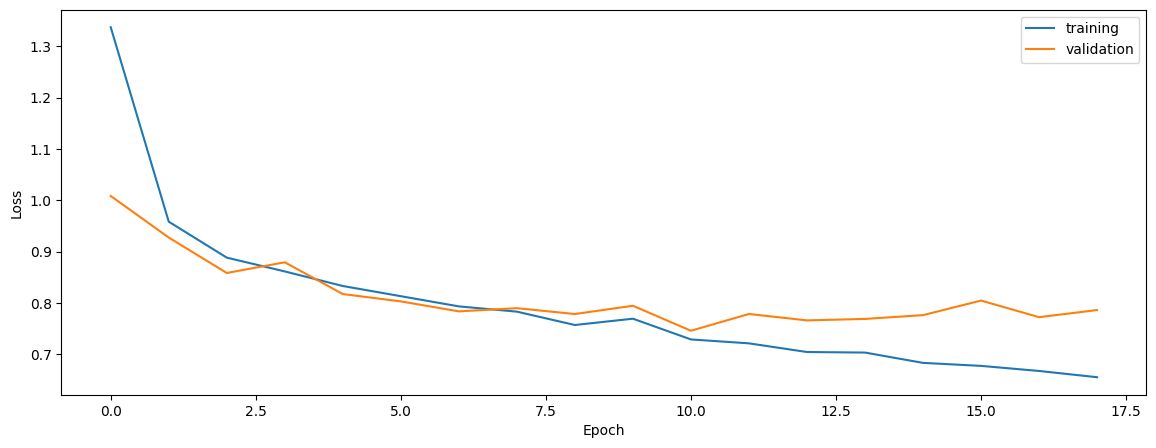

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7466718381718337
0.7416291967021502
0.7609070987085522


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized


0.7466718381718337
0.7416291967021502
0.7609070987085522


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native


0.7428182203246542
0.7522647759746977
0.7591932283000534


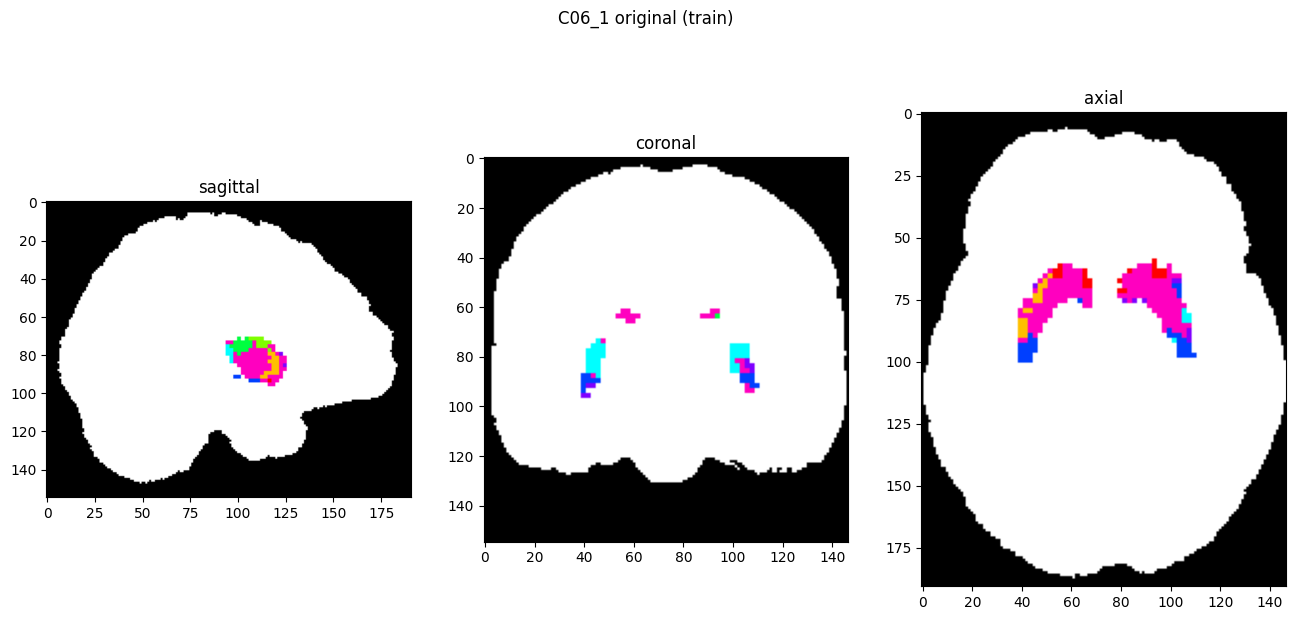

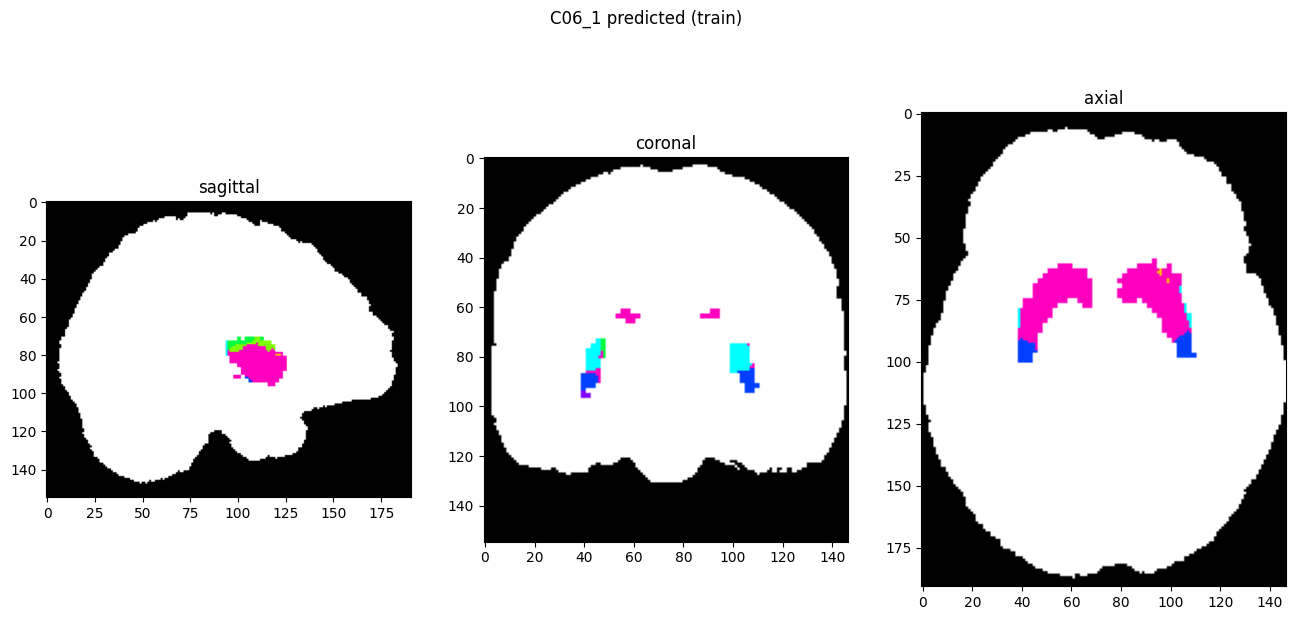

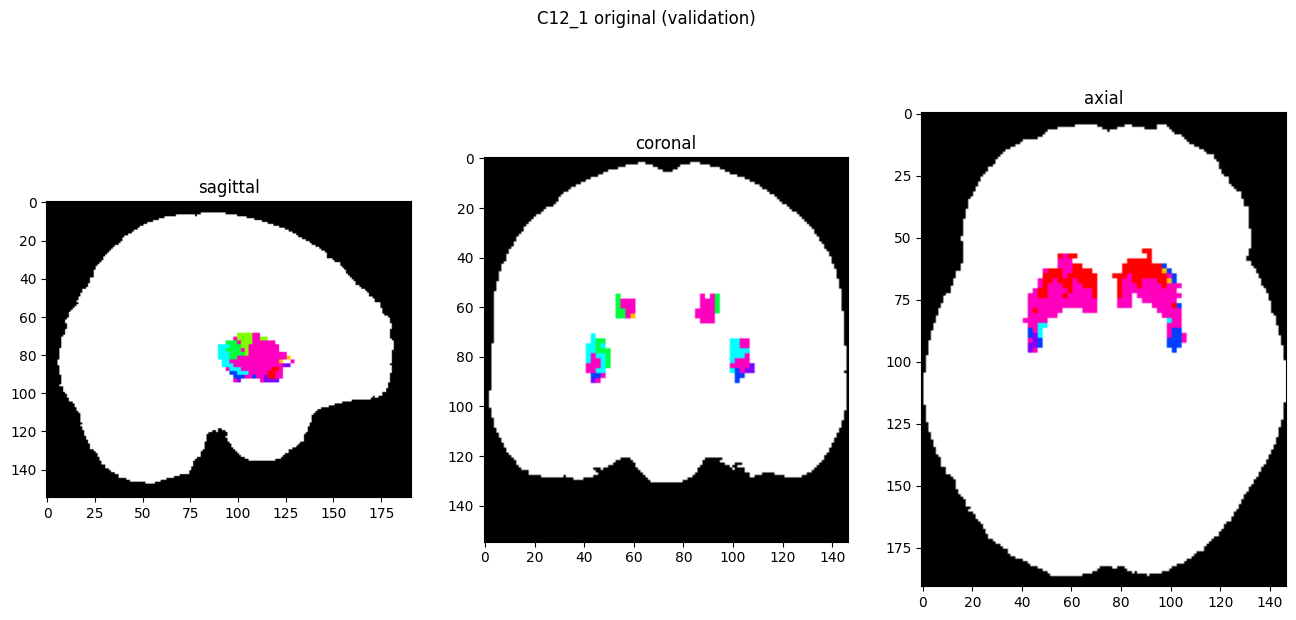

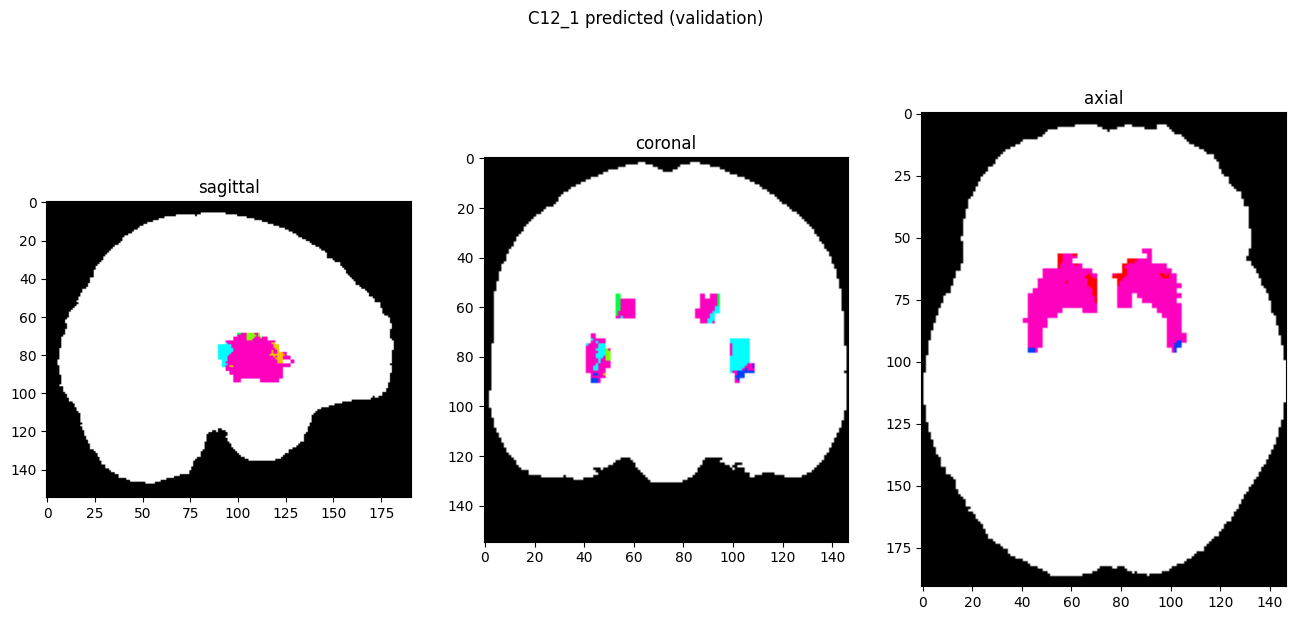

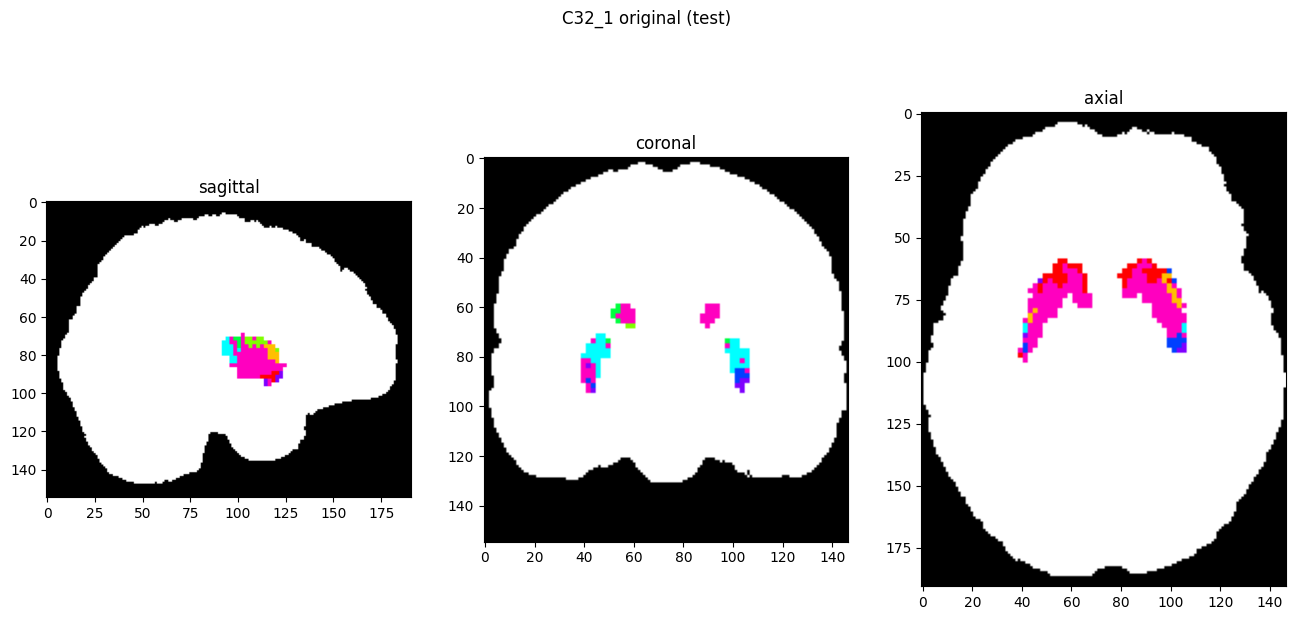

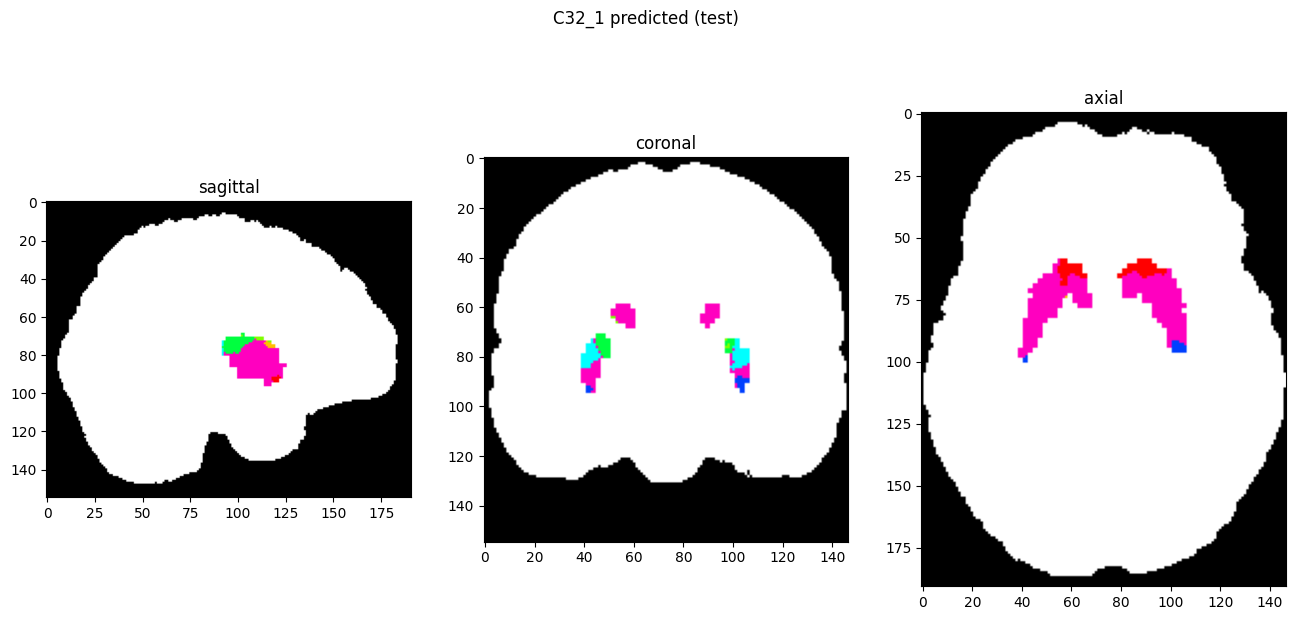

In [10]:
showResults(model, gen, threshold=0)